In [6]:
import torch.nn as nn
from networks import *
from train_utils import *
import matplotlib.pyplot as plt

n_epochs = 42
batch_size = 128
batch_size_test = 1028
device = "cpu"

In [65]:
def trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_accuracy(model, stats):
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    ax.plot(1-stats["train_accuracy"], label="training")
    ax.plot(1-stats["test_accuracy"], label="test")
    ax.set_xlabel("epoch")
    ax.set_ylabel("error")
    fig.legend(loc="center right")
    best_epoch = np.argmax(stats["test_accuracy"])
    print("The minimum test error is {:1.2}% in epoch {}".format((1-stats["test_accuracy"][best_epoch])*100, best_epoch))
    print("The model has {:1.2} Million Parameters".format(trainable_params(model)/1e6))

In [66]:
In total I run 6 different experiments on the MNIST dataset. 

SyntaxError: invalid syntax (<ipython-input-66-94d1ca0b23da>, line 1)

# Experiment 1 - Baseline Resnet
The first experiment reproduces the baseline given by "ResNet" in Table 1 of [1]. After downsampling the input six residual layers are applied. Each block consists of two Convolution, ReLU and Normalisation layers. 

In [67]:
resnet_6 = nn.Sequential(*get_downsampling_layers(), *get_residual_blocks(6), *get_final_layers())
trained_resnet_6 = train_model_cached(resnet_6, file_path="cached_models/resnet6.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/resnet6.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ResidualBlock(
    (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_layer1): ReLU(inplace)
    (conv_layer1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
    (norm_layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_layer2): ReLU(inplace)
    (conv_layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  )
  (8): ResidualBlock(
    (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=

The minimum test error is 0.42% in epoch 17
The model has 0.53 Million Parameters


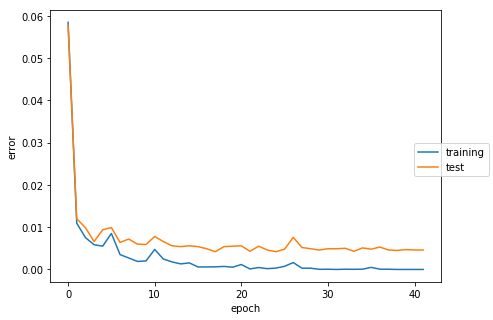

In [68]:
plot_accuracy(*trained_resnet_6)

The best test error of 0.42% almoust perfectly replicates the error of 0.41% reported in [1] (Table 1 "ResNet"). However the architecture I am using has 70k less parameters then the number of parameters reported in [1]. 

# Experiment 2 - Simpler ResNet
In addition to the previous model, I also try a residual neural network with only a single residual block instead of six. 

In [69]:
simple_resnet = nn.Sequential(*get_downsampling_layers(), *get_residual_blocks(1), *get_final_layers())
simple_resnet_trained = train_model_cached(simple_resnet, file_path="cached_models/simple_resnet1.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/simple_resnet1.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ResidualBlock(
    (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_layer1): ReLU(inplace)
    (conv_layer1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
    (norm_layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_layer2): ReLU(inplace)
    (conv_layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  )
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

The minimum test error is 0.54% in epoch 24
The model has 0.16 Million Parameters


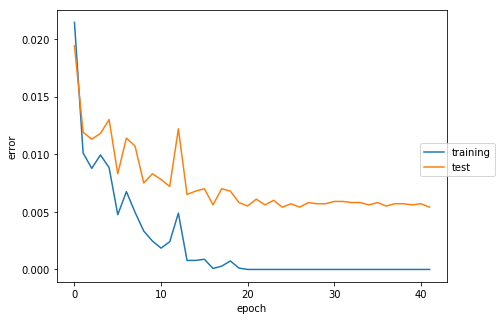

In [70]:
plot_accuracy(*simple_resnet_trained)

This model has only 0.16 Million trainable parameters, which is even fewer then the ODE-Network reported in the paper. 

# Experiment 3 - Default ODE Network (Group-Norm)
This experminet replicates the entry for "ODE-Net" in Table 1 of [1].  


In [72]:
standard_ode_group = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=True, norm_type="group"), device=device), *get_final_layers())
standard_ode_group_trained = train_model_cached(standard_ode_group, file_path="cached_models/ode_group.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/ode_group.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ODEBlock(
    (dynamics_function): ConvolutionalDynamicsFunction(
      (norm_layer1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu_layer1): ReLU(inplace)
      (conv_layer1): TimeDependentConv(
        (conv_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
      )
      (norm_layer2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu_layer2): ReLU(inplace)
      (conv_layer2): TimeDependentConv(
        (conv_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  

The minimum test error is 0.48% in epoch 38
The model has 0.16 Million Parameters


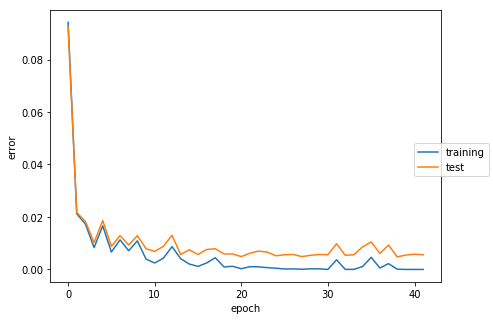

In [73]:
plot_accuracy(*standard_ode_group_trained)

# Experiment 4 - Default ODE Network (Batch Norm)

In [74]:
standard_ode_batch = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=True, norm_type="batch"), device=device), *get_final_layers())
standard_ode_batch_trained = train_model_cached(standard_ode_batch, file_path="cached_models/ode_batch.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/ode_batch.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ODEBlock(
    (dynamics_function): ConvolutionalDynamicsFunction(
      (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_layer1): ReLU(inplace)
      (conv_layer1): TimeDependentConv(
        (conv_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
      )
      (norm_layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_layer2): ReLU(inplace)
      (conv_layer2): TimeDependentConv(
        (conv_layer)

The minimum test error is 0.68% in epoch 39
The model has 0.16 Million Parameters


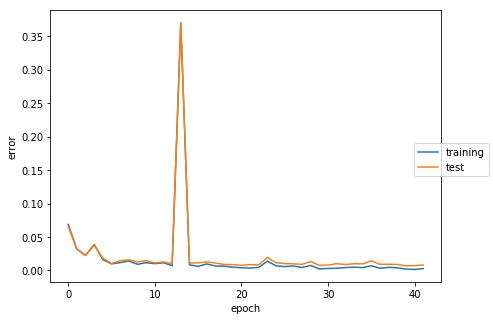

In [75]:
plot_accuracy(*standard_ode_batch_trained)

## Experiment 3.1 - ODE-Net without time dependence 

In [76]:
no_time_ode_group = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=False, norm_type="group"), device=device), *get_final_layers())
no_time_ode_group_trained = train_model_cached(no_time_ode_group, file_path="cached_models/no_time_ode_group.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/no_time_ode_group.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ODEBlock(
    (dynamics_function): ConvolutionalDynamicsFunction(
      (norm_layer1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu_layer1): ReLU(inplace)
      (conv_layer1): TimeDependentConv(
        (conv_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
      )
      (norm_layer2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu_layer2): ReLU(inplace)
      (conv_layer2): TimeDependentConv(
        (conv_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, T

The minimum test error is 0.48% in epoch 32
The model has 0.16 Million Parameters


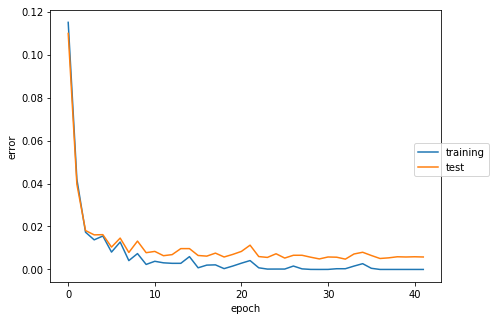

In [77]:
plot_accuracy(*no_time_ode_group_trained)

## Experiment 3.2 -  ODE-Net without time dependence (Batch-Norm)

In [80]:
no_time_ode_batch = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=False, norm_type="batch"), device=device), *get_final_layers())
no_time_ode_batch_trained = train_model_cached(no_time_ode_batch, file_path="cached_models/no_time_ode_batch.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/no_time_ode_batch.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ODEBlock(
    (dynamics_function): ConvolutionalDynamicsFunction(
      (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_layer1): ReLU(inplace)
      (conv_layer1): TimeDependentConv(
        (conv_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
      )
      (norm_layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_layer2): ReLU(inplace)
      (conv_layer2): TimeDependentConv(
        (con

# Sources

[1] Neural Ordinary Differential Equations; Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David Duvenaud (2019)
 